### Generic imports

In [1]:
# Force tokenizers to run in parallel
%env TOKENIZERS_PARALLELISM=true
%env HF_DATASETS_CACHE=hf_cache
%env NCCL_DEBUG=INFO
%env CUDA_VISIBLE_DEVICES=2,4,5
import wandb
import torch
import numpy as np
import faiss
from collections import Counter
import matplotlib.pyplot as plt

# Check if CUDA is available (Docker attached correctly)
print(f"CUDA: {torch.cuda.is_available()}")

env: TOKENIZERS_PARALLELISM=true
env: HF_DATASETS_CACHE=hf_cache
env: NCCL_DEBUG=INFO
env: CUDA_VISIBLE_DEVICES=2,4,5
CUDA: True


In [2]:
print(torch.cuda.device_count())

3


#### Tokenizer set up

# TraceBERT Model

### Load pretrained tokenizer fast

HuggingFace nicely provided a high performance Rust implementation, let's use it.

In [4]:
from transformers import PreTrainedTokenizerFast, BertTokenizerFast
fast_tokenizer = BertTokenizerFast(
                                        tokenizer_file="trace_tokenizer_no_method_uniq.json",
                                        return_special_tokens_mask=True,
                                        return_token_type_ids=True
                                    )

In [8]:
fast_tokenizer.vocab_size

5349

## Load datasets

In [2]:
from datasets import load_dataset
import datasets

In [10]:
train_dataset = load_dataset(
                        'text',
                        data_files='../projsplit/both_r.txt',
                        split='train[:95%]' # Load first 5% of dataset
                    )

Using custom data configuration default-78bed58c10c1f06d
Reusing dataset text (hf_cache/text/default-78bed58c10c1f06d/0.0.0/d86c40dad297bdddf277b406c6a59f0250b5318c400bf23d420a31aff88c84c4)


In [11]:
test_dataset = load_dataset(
                        'text',
                        data_files='../projsplit/both_r.txt',
                        split='train[95%:100%]' # Load 3k rows for test
                    )

Using custom data configuration default-78bed58c10c1f06d
Reusing dataset text (hf_cache/text/default-78bed58c10c1f06d/0.0.0/d86c40dad297bdddf277b406c6a59f0250b5318c400bf23d420a31aff88c84c4)


## Tokenize/encode datasets

In [ ]:
# Define tokenization function
# Max length: length of model
# Truncation: true (defaults to max example length)
# Padding: true (until truncation length)
def tokenize_trace(examples):
    return {
        **fast_tokenizer(
            examples['method_body'],
            max_length = tracebert_config.hidden_size,
            truncation=True,
            padding=True
        )
    }

def extract_trace(examples):
        return { 'method_name': [ t[:t.index(' ')] for t in examples['text'] ],
        'method_body': [ t[t.index(' ')+1:] for t in examples['text'] ] }

#### Tokenize training dataset

In [ ]:
google_train_dataset_enc = (google_train_dataset
                            .map(
                                            extract_trace,
                                            batched=True
                                        )
                            .remove_columns('text')
                            .map(
                                            tokenize_trace,
                                            batched=True,
                                num_proc=32
                                        )
                           )

In [ ]:
# Sanity check
google_train_dataset_enc[0]

In [ ]:
# Save tokenized version
google_train_dataset_enc.save_to_disk('datasets/google_train_dataset_enc_no_name_27m')

#### Tokenize test dataset

In [ ]:
google_test_dataset_enc = (google_test_dataset.map(
                                            extract_trace,
                                            batched=True
                                        ).remove_columns('text')
                            .map(
                                            tokenize_trace,
                                            batched=True,
                                num_proc=32
                                        )
                           )

In [ ]:
# Sanity check
google_test_dataset_enc

In [ ]:
# Save tokenized version
google_test_dataset_enc.save_to_disk('datasets/google_test_dataset_enc_no_2_7m')

### Load tokenized datasets (if already saved)

In [29]:
google_train_dataset_enc = datasets.load_from_disk('datasets/both_uniq_no_name')
google_test_dataset_enc = datasets.load_from_disk('datasets/test_dataset_enc_uniq_no_name')

## Inspect datasets

In [13]:
train_func_frequencies = Counter(google_train_dataset_enc['method_name']).most_common()

In [14]:
train_func_frequencies

[('write', 1065),
 ('writeLoopOnConverters', 979),
 ('get', 888),
 ('doEncode', 841),
 ('run', 706),
 ('getInt', 618),
 ('setInt', 601),
 ('isLiveNonVolatile', 517),
 ('debug', 517),
 ('doAppend', 434),
 ('append', 421),
 ('encode3to4', 409),
 ('checkIndex', 407),
 ('subAppend', 396),
 ('getInstance', 388),
 ('handlePossibleBridgeMethod', 371),
 ('hashCode', 369),
 ('unsafeOffset', 367),
 ('log', 366),
 ('isAccessible', 362),
 ('getUnsignedMedium', 357),
 ('DefaultThreadFactory', 348),
 ('addListener', 344),
 ('newChild', 340),
 ('ensureAccessible', 338),
 ('BaseMpscLinkedArrayQueue', 333),
 ('newMpscQueue', 323),
 ('apply', 313),
 ('writeOut', 310),
 ('getFilterChainDecision', 309),
 ('checkIndex0', 306),
 ('MultithreadEventExecutorGroup', 303),
 ('fullPathMatch', 298),
 ('_setInt', 288),
 ('expand', 287),
 ('appendLoopOnAppenders', 277),
 ('containsValue', 268),
 ('SingleThreadEventExecutor', 239),
 ('checkRangeBounds', 239),
 ('getMedium', 235),
 ('putInt', 234),
 ('_getUnsignedMedi

In [11]:
test_func_frequencies = Counter(google_test_dataset_enc['method_name']).most_common()

In [5]:
num_calls = google_train_dataset_enc.map(lambda x: {'num_calls': x['method_body'].count('[CALL]')})

Loading cached processed dataset at datasets/both_uniq_no_name/cache-3cce61c526b0343f.arrow


In [48]:
Counter(num_calls['num_calls']).most_common()

[(0, 17853),
 (1, 6798),
 (2, 4826),
 (3, 2938),
 (4, 2588),
 (6, 1798),
 (5, 1733),
 (8, 1162),
 (7, 1136),
 (9, 818),
 (10, 812),
 (11, 543),
 (12, 532),
 (16, 487),
 (13, 437),
 (14, 407),
 (18, 393),
 (19, 387),
 (17, 348),
 (15, 316),
 (20, 300),
 (21, 261),
 (22, 218),
 (34, 204),
 (23, 199),
 (26, 195),
 (28, 194),
 (25, 192),
 (31, 180),
 (44, 168),
 (24, 166),
 (36, 165),
 (32, 162),
 (35, 147),
 (33, 145),
 (27, 138),
 (29, 138),
 (30, 138),
 (37, 124),
 (38, 120),
 (41, 110),
 (40, 104),
 (45, 104),
 (46, 101),
 (42, 98),
 (39, 95),
 (48, 92),
 (47, 90),
 (50, 77),
 (49, 70),
 (53, 69),
 (43, 68),
 (54, 65),
 (59, 64),
 (51, 62),
 (72, 59),
 (52, 58),
 (68, 58),
 (56, 55),
 (58, 53),
 (60, 52),
 (71, 52),
 (55, 52),
 (57, 51),
 (62, 49),
 (114, 45),
 (77, 43),
 (61, 43),
 (76, 42),
 (65, 41),
 (63, 41),
 (73, 41),
 (67, 40),
 (66, 40),
 (70, 39),
 (90, 39),
 (69, 39),
 (88, 38),
 (109, 37),
 (74, 36),
 (75, 35),
 (83, 34),
 (64, 33),
 (78, 31),
 (79, 31),
 (84, 30),
 (82, 29

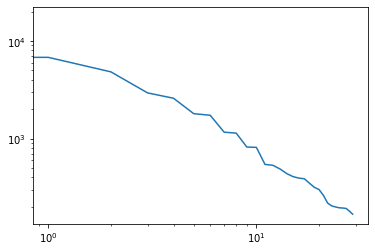

In [7]:
plot_freq(Counter(num_calls['num_calls']).most_common()[:30])

In [6]:
def plot_freq(counter):
    counts = [ (index, value[1]) for index, value in enumerate(counter) ]
    plt.plot(*zip(*counts))
    plt.yscale('log')
    plt.xscale('log')
    # plt.savefig("num_calls.pdf")
    plt.show()

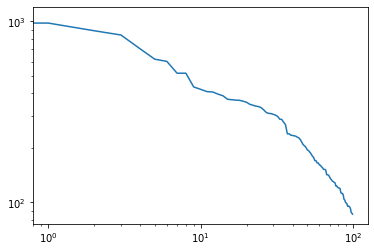

[('write', 1065), ('writeLoopOnConverters', 979), ('get', 888), ('doEncode', 841), ('run', 706), ('getInt', 618), ('setInt', 601), ('isLiveNonVolatile', 517), ('debug', 517), ('doAppend', 434), ('append', 421), ('encode3to4', 409), ('checkIndex', 407), ('subAppend', 396), ('getInstance', 388)]


In [15]:
plot_freq(train_func_frequencies[:100])
print(train_func_frequencies[:15])

In [34]:
# We need 100 method names with at least 30 examples
min([ value[1] for value in train_func_frequencies[:222] ])

29

In [35]:
atleast_thirty = train_func_frequencies[:221]

In [36]:
atleast_thirty

221

In [32]:
google_train_dataset_enc = google_train_dataset_enc.map(lambda x: { 'len': len(trim(x['input_ids'],trim_value=3)) })



Loading cached processed dataset at datasets/both_uniq_no_name/cache-cc642b0c688c80fc.arrow


# Interpret model

### Retrieve examples of specific function name

In [31]:
def exact_str_match(x,y):
    return x==y
def str_contains(x,y):
    return x in y

def trim(filt, trim_value=0., trim='fb'):
    """
    Copied from np.trim_zeros, but allows the trim value to be specified
    """
    first = 0
    trim = trim.upper()
    if 'F' in trim:
        for i in filt:
            if i != trim_value:
                break
            else:
                first = first + 1
    last = len(filt)
    if 'B' in trim:
        for i in filt[::-1]:
            if i != trim_value:
                break
            else:
                last = last - 1
    return filt[first:last]

# pass comparator which (x,y) where x is needle and y is haystack
def retrieve_func_examples(dataset, function_name, comparator=exact_str_match):
    return dataset.filter(lambda trace: comparator(function_name, trace['method_name']), num_proc=64)

def retrieve_func_examples_len(dataset, function_name, length, comparator=exact_str_match):
    return dataset.filter(lambda trace: comparator(function_name, trace['method_name']) and len(trim(trace['input_ids'],trim_value=3)) > length, num_proc=64)

In [45]:
func_compare_google = retrieve_func_examples(
                            google_train_dataset_enc,
                            'compare',
                            comparator=exact_str_match
                        )

Setting TOKENIZERS_PARALLELISM=false for forked processes.
Loading cached processed dataset at datasets/both_uniq_no_name/cache-35e5e44c7d88b386_00000_of_00064.arrow
Loading cached processed dataset at datasets/both_uniq_no_name/cache-35e5e44c7d88b386_00001_of_00064.arrow
Loading cached processed dataset at datasets/both_uniq_no_name/cache-35e5e44c7d88b386_00002_of_00064.arrow
Loading cached processed dataset at datasets/both_uniq_no_name/cache-35e5e44c7d88b386_00003_of_00064.arrow
Loading cached processed dataset at datasets/both_uniq_no_name/cache-35e5e44c7d88b386_00004_of_00064.arrow
Loading cached processed dataset at datasets/both_uniq_no_name/cache-35e5e44c7d88b386_00005_of_00064.arrow
Loading cached processed dataset at datasets/both_uniq_no_name/cache-35e5e44c7d88b386_00006_of_00064.arrow
Loading cached processed dataset at datasets/both_uniq_no_name/cache-35e5e44c7d88b386_00007_of_00064.arrow
Loading cached processed dataset at datasets/both_uniq_no_name/cache-35e5e44c7d88b386

In [46]:
func_compare_google

Dataset({
    features: ['method_name', 'method_body', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 73
})

Now we have two datasets with an equal amount of examples for a particular method, we now load these examples into the model and extract the embeddings

# (Re)load pretrained model for embeddings

In [23]:
import statistics
import random
from tqdm.notebook import trange, tqdm
from transformers import TrainingArguments, DataCollatorForWholeWordMask, Trainer, BertForMaskedLM

If the model is not loaded yet, select a pretrained model to generate embeddings

In [25]:
tracebert_model = BertForMaskedLM.from_pretrained('tracebert_013')
# or 
# or BertModel.from_pretrained('path_to_model_dir', add_pooling_layer=True)
#tracebert_model

We must ensure/assert that the model class will return the hidden states

In [26]:
tracebert_model.config.output_hidden_states = True
tracebert_model.config.return_dict = True
assert tracebert_model.config.output_hidden_states == True

Define a function to load examples and extract hidden states from model as numpy arrays

In [27]:
from torch.nn.utils.rnn import pad_sequence

def calculate_embeddings(examples, method='hidden_state'):
    with torch.no_grad(): # no autograd if we don't train
        if method == 'hidden_state':
            # get the hidden state of the [CLS] token
            # we first grab the hidden states from the model,
            # then take the last layer, [-1], and convert it to a 3D
            # numpy array. N is number of examples in batch.
            # L is number of tokens (longest example fixes L)
            # D is number of hidden states
            # the shape is (N, L, D)
            # since [CLS] is always first, if we slice
            # (N, L[:1], D) we will get the hidden dim of the [CLS] token.
            # since L is now always 1, it is useless, and we can squeeze it out
            # now the shape is (N, D) where each example has 512 vectors
             # **fast_tokenizer(
             #    examples['method_body'],
             #    max_length = tracebert_config.hidden_size,
             #    truncation=True,
             #    padding=True,
             #         return_tensors="pt"
            #print(f"input_ids={torch.tensor(examples['input_ids']).shape}, attention_mask={torch.tensor(examples['attention_mask']).shape}, token_type_ids={torch.tensor(examples['token_type_ids']).shape}")
            b = tracebert_model(
                        input_ids=pad_sequence([torch.tensor(x) for x in examples['input_ids']], padding_value=3, batch_first=True),
                        attention_mask=pad_sequence([torch.tensor(x) for x in examples['attention_mask']], batch_first=True),
                        token_type_ids=pad_sequence([torch.tensor(x) for x in examples['token_type_ids']], batch_first=True)
                    ).hidden_states[-1].numpy()[:,:1,:].squeeze()
            return { 'embedding': b }
        elif method == 'pooler_output':
            return tracebert_model(examples).pooler_output.numpy() # shape [n, 512]

In [34]:
longish = google_train_dataset_enc.filter(lambda x: x['len'] > 10)

Loading cached processed dataset at datasets/both_uniq_no_name/cache-70c5c517e2022014.arrow


In [35]:
counts_t = dict(Counter(longish['method_name']))

In [36]:
filtered = dict(filter(lambda elem: elem[1] > 30, counts_t.items()))

In [37]:
len(filtered)

146

In [38]:
sample_hundred_func_names = random.sample(sorted(filtered), 100)

In [39]:
hundred_funcs = {
}

for func in tqdm(sample_hundred_func_names):
    hundred_funcs[func] = google_train_dataset_enc.filter(lambda x: x['method_name'] == func and x['len'] > 10, num_proc=4)


  0%|          | 0/100 [00:00<?, ?it/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.
Loading cached processed dataset at datasets/both_uniq_no_name/cache-929229ee74bdf4f9_00000_of_00004.arrow
Loading cached processed dataset at datasets/both_uniq_no_name/cache-929229ee74bdf4f9_00001_of_00004.arrow
Loading cached processed dataset at datasets/both_uniq_no_name/cache-929229ee74bdf4f9_00002_of_00004.arrow
Loading cached processed dataset at datasets/both_uniq_no_name/cache-929229ee74bdf4f9_00003_of_00004.arrow
Loading cached processed dataset at datasets/both_uniq_no_name/cache-0fa337cd144b7918_00000_of_00004.arrow
Loading cached processed dataset at datasets/both_uniq_no_name/cache-0fa337cd144b7918_00001_of_00004.arrow
Loading cached processed dataset at datasets/both_uniq_no_name/cache-0fa337cd144b7918_00002_of_00004.arrow
Loading cached processed dataset at datasets/both_uniq_no_name/cache-0fa337cd144b7918_00003_of_00004.arrow
Loading cached processed dataset at datasets/both_uniq_no_name/cache-4053171993556a14

In [40]:
hundred_funcs

{'openSelector': Dataset({
     features: ['method_name', 'method_body', 'input_ids', 'token_type_ids', 'attention_mask', 'len'],
     num_rows: 197
 }),
 'validateTestClass': Dataset({
     features: ['method_name', 'method_body', 'input_ids', 'token_type_ids', 'attention_mask', 'len'],
     num_rows: 51
 }),
 'MultithreadEventExecutorGroup': Dataset({
     features: ['method_name', 'method_body', 'input_ids', 'token_type_ids', 'attention_mask', 'len'],
     num_rows: 245
 }),
 'newMpscQueue': Dataset({
     features: ['method_name', 'method_body', 'input_ids', 'token_type_ids', 'attention_mask', 'len'],
     num_rows: 210
 }),
 'BaseMpscLinkedArrayQueue': Dataset({
     features: ['method_name', 'method_body', 'input_ids', 'token_type_ids', 'attention_mask', 'len'],
     num_rows: 332
 }),
 'ipStringToBytes': Dataset({
     features: ['method_name', 'method_body', 'input_ids', 'token_type_ids', 'attention_mask', 'len'],
     num_rows: 92
 }),
 'putUnencodedChars': Dataset({
     feat

In [67]:
hundred_funcs_thirty = {k: v.select(range(0,30)) for k, v in hundred_funcs.items()} # ten_funcs.map(lambda x: x.select(0,3))

In [77]:
hundred_funcs_thirty = {k: v.map(calculate_embeddings, batched=True) for k, v in tqdm(hundred_funcs_thirty.items())}

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [42]:
hundred_funcs = {k: v.map(calculate_embeddings, batched=True) for k, v in tqdm(hundred_funcs.items())}

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Prem: 100 method names, for each example 10 times as many examples

#  How many traces have exactly one system call? (0, 17853), (1, 6798)

Approaches: 

In [ ]:
#distances = {}
#for function_name,function_dataset in ten_funcs_three.items():
#    print(function_dataset)
#for entry in function_dataset['test']:
fifty_tests = hundred_funcs['test'].select(range(1,51))

In [103]:
def get_fifty_others(ignore, count):
    fifty_others = [] #np.array([])
    for function_name,function_dataset in hundred_funcs.items():
        if function_name == ignore:
            continue
        #print(len(function_dataset))
        #print(len(
        sample = function_dataset.select(range(0,3))
        emb = np.array(sample['embedding'])
        #print(emb.shape)
        #['embedding']
        #fifty_others = np.append(fifty_others, emb, axis=1)
        fifty_others.extend(emb)
    return np.array(fifty_others[:count])

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

In [120]:
def t_test_method(method, off, ax):
    
    fifty_test_emb = np.array(hundred_funcs[method]['embedding'][(off+1):(51+off)])
    
    fifty_one_test = np.array([hundred_funcs_thirty[method][off]['embedding'] for x in range(0,fifty_test_emb.shape[0])])
    fifty_others = get_fifty_others(method, (fifty_test_emb.shape[0]))
    f_test_others = np.linalg.norm(fifty_one_test-fifty_others,axis=1)
    f_test_self = np.linalg.norm(fifty_one_test[:(fifty_test_emb.shape[0])]-fifty_test_emb,axis=1)
    df = pd.concat([pd.DataFrame({'test': 'Same method names', 'score': f_test_self}), pd.DataFrame({'test': 'Different method names', 'score': f_test_others})])
    sns.boxplot(x='test',y='score',data=df, ax = ax)
    ttest = stats.ttest_rel(f_test_self, f_test_others)
    statistic, pvalue = ttest
    ax.set(xlabel=f"Group of {(fifty_test_emb.shape[0])} \"{method}\" method sample {off+1} (T: {round(statistic,2)}, p-val: {round(pvalue,10)})", ylabel='Norms')
    #plt.savefig(f"{method}_{off}_boxplot.pdf")
    return f_test_self, f_test_others

In [ ]:
t_test_method('test', 0)

In [ ]:


sns.distplot(df.Principal,ax=ax)
ax = fig.add_subplot(2, 2, 2)
sns.distplot(df.terms,ax=ax)
ax = fig.add_subplot(2, 2, 3)
sns.barplot(data = df[['Less_than_College', 'college', 'Bachelor']],ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax = fig.add_subplot(2, 2, 4)
sns.boxplot(df['age'],ax=ax)
plt.show()

In [217]:
test_self = np.array([])
test_others = np.array([])
for method,function_dataset in hundred_funcs.items():
    # fig = plt.figure()
    # fig.set_size_inches(12, 6)
    # fig.subplots_adjust(hspace=0.4, wspace=0.4)
    row = 1
    print(f"{method}")
    # for i in range(0,2):
    #     ax = fig.add_subplot(1, 2, row)
    #     selff,other = t_test_method(method, i, ax)
    #     test_self = np.concatenate([test_self, selff])
    #     test_others = np.concatenate([test_others, other])
    #     row += 1
    #     print(f"    Testing {i+1}/2: {r}")
    #plt.savefig(f"t_test{method}.pdf")
    # plt.close('all')

validateName
trace
LocatorImpl
putObject
MpscUnboundedArrayQueue
add
getFilterChainDecision
process
filter
test
addAll
unsafeOffset
handlePossibleBridgeMethod
writeOut
addRule
insertRandomCharacters
Eopt
DefaultThreadFactory
isValidIdentifier
expand
doEncode
isValidIpV6Address
getIPv6ByName
append
validatePublicVoidNoArgMethods
newChooser
addListener
hashLength65Plus
objectFieldOffset
getPropertyName
simpleClassName
MultithreadEventExecutorGroup
AbstractByteBufAllocator
contentEquals
ensureAccessible
subAppend
T
NioEventLoopGroup
newStatic
addChildrenRecursively
canDecode
parse
access$000
contains
isAcyclic
appendLoopOnAppenders
isSkippable
textToNumericFormatV6
FileDescriptor
putBytesInternal
LocationAwareSlf4JLogger
getBoolean
escapeCsv
endElement
EpollEventLoopGroup
appendDescriptor
newTaskQueue0
getSystemClassLoader
IntObjectHashMap
directBufferAddress
setInt
addressesFromNetworkInterface
set
encodedLengthGeneral
readLine
validateTestClass
threadLocalRandom
debug
AbstractScheduledE

In [126]:
test_self.shape

(9243,)

In [127]:
test_others.shape

(9243,)

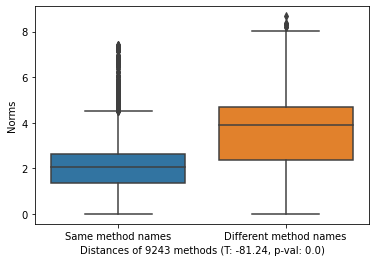

In [145]:
fig = plt.figure()
#fig.set_size_inches(12, 6)
ax = fig.add_subplot()
df = pd.concat([pd.DataFrame({'test': 'Same method names', 'score': test_self}), pd.DataFrame({'test': 'Different method names', 'score': test_others})])
sns.boxplot(x='test',y='score',data=df, ax = ax)
ttest = stats.ttest_rel(test_self, test_others)
statistic, pvalue = ttest
ax.set(xlabel=f"Distances of {test_self.shape[0]} methods (T: {round(statistic,2)}, p-val: {round(pvalue,10)})", ylabel='Norms')
plt.savefig("all_methods.pdf")

In [139]:
plt.show()

In [ ]:
x = ten_funcs['test'].unique('method_body')

In [ ]:
x 

In [ ]:
[(a, b) for idx, a in enumerate(test_list) for b in test_list[idx + 1:]]

In [ ]:
google_compare_emb = func_compare_google.select(range(0,250)).map(calculate_embeddings, batched=True)

In [ ]:
netty_compare_emb = func_compare_netty.map(calculate_embeddings, batched=True)

In [ ]:
func_CPI_google_emb = func_CPI_google.select(range(0,250)).map(calculate_embeddings, batched=True)

Sanity check that shapes match

In [ ]:
assert np.array(google_compare_emb['embedding']).shape[0] == np.array(netty_compare_emb['embedding']).shape[0]
assert np.array(google_compare_emb['embedding']).shape[1] == np.array(netty_compare_emb['embedding']).shape[1]
assert np.array(google_compare_emb['embedding']).shape[0] == minimum_funcs
assert np.array(google_compare_emb['embedding']).shape[1] == tracebert_model.config.hidden_size

## Add embeddings to dataset and search

We start by selecting a more workable subset of the Google dataset

In [ ]:
ten_k_google = (
                google_train_dataset_enc
                .select(range(0,10000))
                .map(
                      calculate_embeddings,
                      batched=True
                    )
                )

In [ ]:
ten_k_google = ten_k_google.map(lambda x: {'len': len(x['method_body']) })

In [ ]:
ten_k_google.filter(lambda x: x['len'] > 350 and x['method_name'] == 'compare')[0]

In [ ]:
ten_k_google.load_faiss_index('index_flat_ip', 'ten_k_google_ip.faiss')

In [ ]:
ten_k_google.load_faiss_index('index_flat_l2', 'ten_k_google_l2.faiss')

We add a FAISS index to make this dataset searchable

TODO: A custom index can/should be used to improve performance. There are many, many indexes to choose from and have complexity and space considerations, and exhaustion considerations. We can probably handle much, much more traces if we figure this out. Upfront compute is probably higher as well.

In [ ]:
# this is the DEFAULT config, seems to be flat index with IP metric
# note there is a problem with this index: the vectors are supposed to be
# normalized for inner product if we want to find cosine similarity
ten_k_google.add_faiss_index(
    column='embedding',
    index_name='index_flat_ip',
    #device=0, # GPU index
    # passed to faiss.index_factory(), defaults to IndexFlatIP
    string_factory='Flat',
    metric_type=faiss.METRIC_INNER_PRODUCT, # or faiss.METRIC_INNER_PRODUCT
    #custom_index= can specify a custom index object for more power
    #train_size: Optional[int] = None,
    faiss_verbose=True
)

In [ ]:
# let's add an index with L2 distance
ten_k_google.add_faiss_index(
    column='embedding',
    index_name='index_flat_l2',
    #device=0, # GPU index
    string_factory='Flat',
    metric_type=faiss.METRIC_L2,
    #custom_index= can specify a custom index object for more power
    #train_size: Optional[int] = None,
    faiss_verbose=True
)

Let's check if we can access our index directly...

In [ ]:
faiss_index = ten_k_google.get_index('index_flat_ip') # this should return a FAISS object
faiss_index

We save the index so that we don't have to recalculate next time

In [ ]:
ten_k_google.save_faiss_index('index_flat_ip', 'ten_k_google_ip.faiss')
ten_k_google.save_faiss_index('index_flat_l2', 'ten_k_google_l2.faiss')

As a sanity check, we search for an example in the dataset/index and evaluate the top ten results

In [ ]:
random_example_in = ten_k_google[np.random.randint(0, len(ten_k_google))]
random_example_in

In [ ]:
np.array(random_example_in['embedding']).shape

In [ ]:
scores, examples = ten_k_google.get_nearest_examples('index_flat_ip',
                                  np.array(random_example_in['embedding']).astype('float32'),
                                  k=10)

In [ ]:
random_example_in['text']

In [ ]:
# so why are traces with the exact same 'text' not the same distance?

In [ ]:
list(zip(scores, np.sqrt(scores), examples['text']))

We then load one example not in the smaller dataset

In [ ]:
random_example_out = google_train_dataset_enc[np.random.randint(10000, len(google_train_dataset_enc))]

In [ ]:
random_example_out['embedding'] = np.array(calculate_embeddings({'input_ids': [random_example_out['input_ids']],
                                                        'token_type_ids': [random_example_out['token_type_ids']],
                                                        'attention_mask': [random_example_out['attention_mask']] })['embedding'])

In [ ]:
# Sanity check on embedding dim
assert random_example_out['embedding'].shape == (512,)
random_example_out['embedding'].shape

We then search for the example outside of the dataset and evaluate the top 10 results

In [ ]:
# inner product
scores, results = ten_k_google.get_nearest_examples('index_flat_ip', np.array(random_example_out['embedding']).astype('float32'), k=10)


In [ ]:
random_example_out['func_name']

In [ ]:
list(zip(scores, examples['func_name']))

In [ ]:
# l2
ten_k_google.get_nearest_examples('ten_k_google_l2', np.array(random_example_out['embedding']).astype('float32'), k=3)


In [ ]:
# l2 search/distance
distance, index = ten_k_google.get_index('index_flat_l2').search(np.array(random_example_out['embedding']).astype('float32'), k=3)
print(f"Distance by FAISS: {np.sqrt(distance)}, index: {index}")

#### Cosine similarity index + search

Let's create a new index so we can calculate cosine similarity

In [ ]:
random_example_emb = np.array(random_example_out['embedding']).astype('float32')
#x = np.array([random_example_emb])#.astype(np.float32)
#q = np.array([random_example_emb])#.astype(np.float32)
faiss_l2_index = faiss.index_factory(512, "Flat", faiss.METRIC_L2)

For cosine similarity, we *must* normalize the index vectors and the search vectors

In [ ]:
ten_k_emb_norm = np.array(ten_k_google['embedding']).astype('float32')
random_example_emb_in = np.array([random_example_in['embedding']]).astype('float32')
faiss.normalize_L2(ten_k_emb_norm) # must normalize ALL vectors for this index
faiss_l2_index.train(ten_k_emb_norm)
# faiss.normalize_L2(random_example_emb)
faiss_l2_index.add(ten_k_emb_norm)

Sanity check:

In [ ]:
faiss_l2_index.is_trained

In [ ]:
faiss_l2_index.ntotal # should be one
#faiss_l2_index.train(training_vectors)
faiss_l2_index.add(random_example_emb)
distance, index = faiss_l2_index.search(random_example_emb, 1)
print(f"Distance by FAISS: {np.sqrt(distance)}, index: {index}")

In [ ]:
distance, index = faiss_inner_prod_index.search(random_example_emb, 1)
print(f"Distance by FAISS: {distance}, index: {index}")

In [ ]:
# calculate cosine similarity
from scipy import spatial, stats

In [ ]:
result = 1 - spatial.distance.cosine(ten_k_emb_norm[index[0]], random_example_emb)
print(f"Distance by scipy: {result}")

In [ ]:
np.array(google_compare_emb['embedding']).shape

In [ ]:
np.linspace(0, 1, np.array(google_compare_emb['embedding']).shape[0])

In [ ]:
import pandas as pd

In [ ]:
ax1 = np.linalg.norm(np.array(google_compare_emb['embedding'][:125])-np.array(func_CPI_google_emb['embedding'][125:250]), axis=1)

In [ ]:
ax2 = np.linalg.norm(np.array(google_compare_emb['embedding'][:125]),axis=1) - np.linalg.norm(np.array(func_CPI_google_emb['embedding'][125:250]),axis=1)

In [ ]:
ax2 = np.linalg.norm(np.array(google_compare_emb['embedding'][:125]),axis=1) - np.linalg.norm(np.array(func_CPI_google_emb['embedding'][125:250]),axis=1)
pd.DataFrame(ax2).hist(grid=False,
       figsize=(10, 6),
       )
stats.ttest_rel(ax1, ax2)

In [ ]:
stats.ttest_rel(ax1, ax2)

In [ ]:
ax1 = np.linalg.norm(np.array(google_compare_emb['embedding'][:125])-np.array(func_CPI_google_emb['embedding'][125:250]), axis=1)

In [ ]:
ax2 = np.linalg.norm(np.array(google_compare_emb['embedding'][:125]),axis=1) - np.linalg.norm(np.array(func_CPI_google_emb['embedding'][125:250]),axis=1)

In [ ]:
stats.ttest_rel(ax1, ax2)

In [ ]:
np.linalg.norm(np.array(func_CPI_google_emb['embedding'][125:250]),axis=1)

In [ ]:
np.mean(np.linalg.norm(np.array(func_CPI_google_emb['embedding'][125:250]),axis=1))

In [ ]:
np.mean(np.linalg.norm(np.array(google_compare_emb['embedding'][:125]),axis=1))

In [ ]:
np.linalg.norm(np.array(google_compare_emb['embedding'][:250])-np.array(func_CPI_google_emb['embedding'][:250]),axis=1)

In [ ]:
np.array(func_CPI_google_emb['embedding'][:125])

In [ ]:
np.array(func_CPI_google_emb['embedding'][125:250])

In [ ]:
np.array(google_compare_emb['embedding'][:125])-np.array(func_CPI_google_emb['embedding'][:125])

In [ ]:
np.linalg.norm(np.array(google_compare_emb['embedding'][:125])-np.array(func_CPI_google_emb['embedding'][:125]),axis=1)

## t Test

In [ ]:
np.array(google_compare_emb['embedding'][:50])

In [ ]:
np.linalg.norm(np.array(google_compare_emb['embedding'][:125])-np.array(google_compare_emb['embedding'][125:250]))

In [ ]:
np.linalg.norm(np.array(google_compare_emb['embedding'][:250])-np.array(func_CPI_google_emb['embedding'][:250]))

In [ ]:
a = np.linalg.norm(np.array(google_compare_emb['embedding'][:125])-np.array(google_compare_emb['embedding'][125:250]), axis=1)
b = np.linalg.norm(np.array(google_compare_emb['embedding'][125:250])-np.array(func_CPI_google_emb['embedding'][:125]), axis=1)
t, p = stats.ttest_rel(a, b)
(t, p)

# tSNE: Are the embeddings really capturing something useful?

In [21]:
from MulticoreTSNE import MulticoreTSNE as TSNE
#from tsnecuda import TSNE # pkg: tsnecuda
from matplotlib import cm
import matplotlib

In [147]:
def draw_tsne(embeddings, colors):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    embeddings_tsne = TSNE(n_jobs=16).fit_transform(embeddings)
    vis_x_cb = embeddings_tsne[:, 0]
    vis_y_cb = embeddings_tsne[:, 1]
    fig = plt.figure(figsize=(36,24))
    ax = fig.add_subplot(111)
    ax.scatter(vis_x_cb, vis_y_cb, c=colors, marker='.')
    ax.set_aspect('equal', adjustable='datalim')
    plt.show()

In [ ]:
np.concatenate([np.array(netty_compare_emb['embedding']), np.array(google_compare_emb['embedding'])]).shape

In [ ]:
draw_tsne(
    np.concatenate([np.array(netty_compare_emb['embedding']), np.array(google_compare_emb['embedding'])]),
    cm.rainbow(np.concatenate((np.zeros(netty_compare_emb.shape[0]), np.ones(google_compare_emb.shape[0]))))
)

In [43]:
np.concatenate([np.array(value['embedding']) for (key,value) in hundred_funcs.items()]).shape

(14065, 512)

In [45]:
color_indices = []
j = 0
for key,value in tqdm(hundred_funcs.items()):
    color_indices.extend([j for k in range(len(value))])
    j += 1
np.array(color_indices)

  0%|          | 0/100 [00:00<?, ?it/s]

array([ 0,  0,  0, ..., 99, 99, 99])

In [ ]:
np.array(color_indices).shape

In [18]:
import plotly.express as px

<Figure size 1332x756 with 0 Axes>

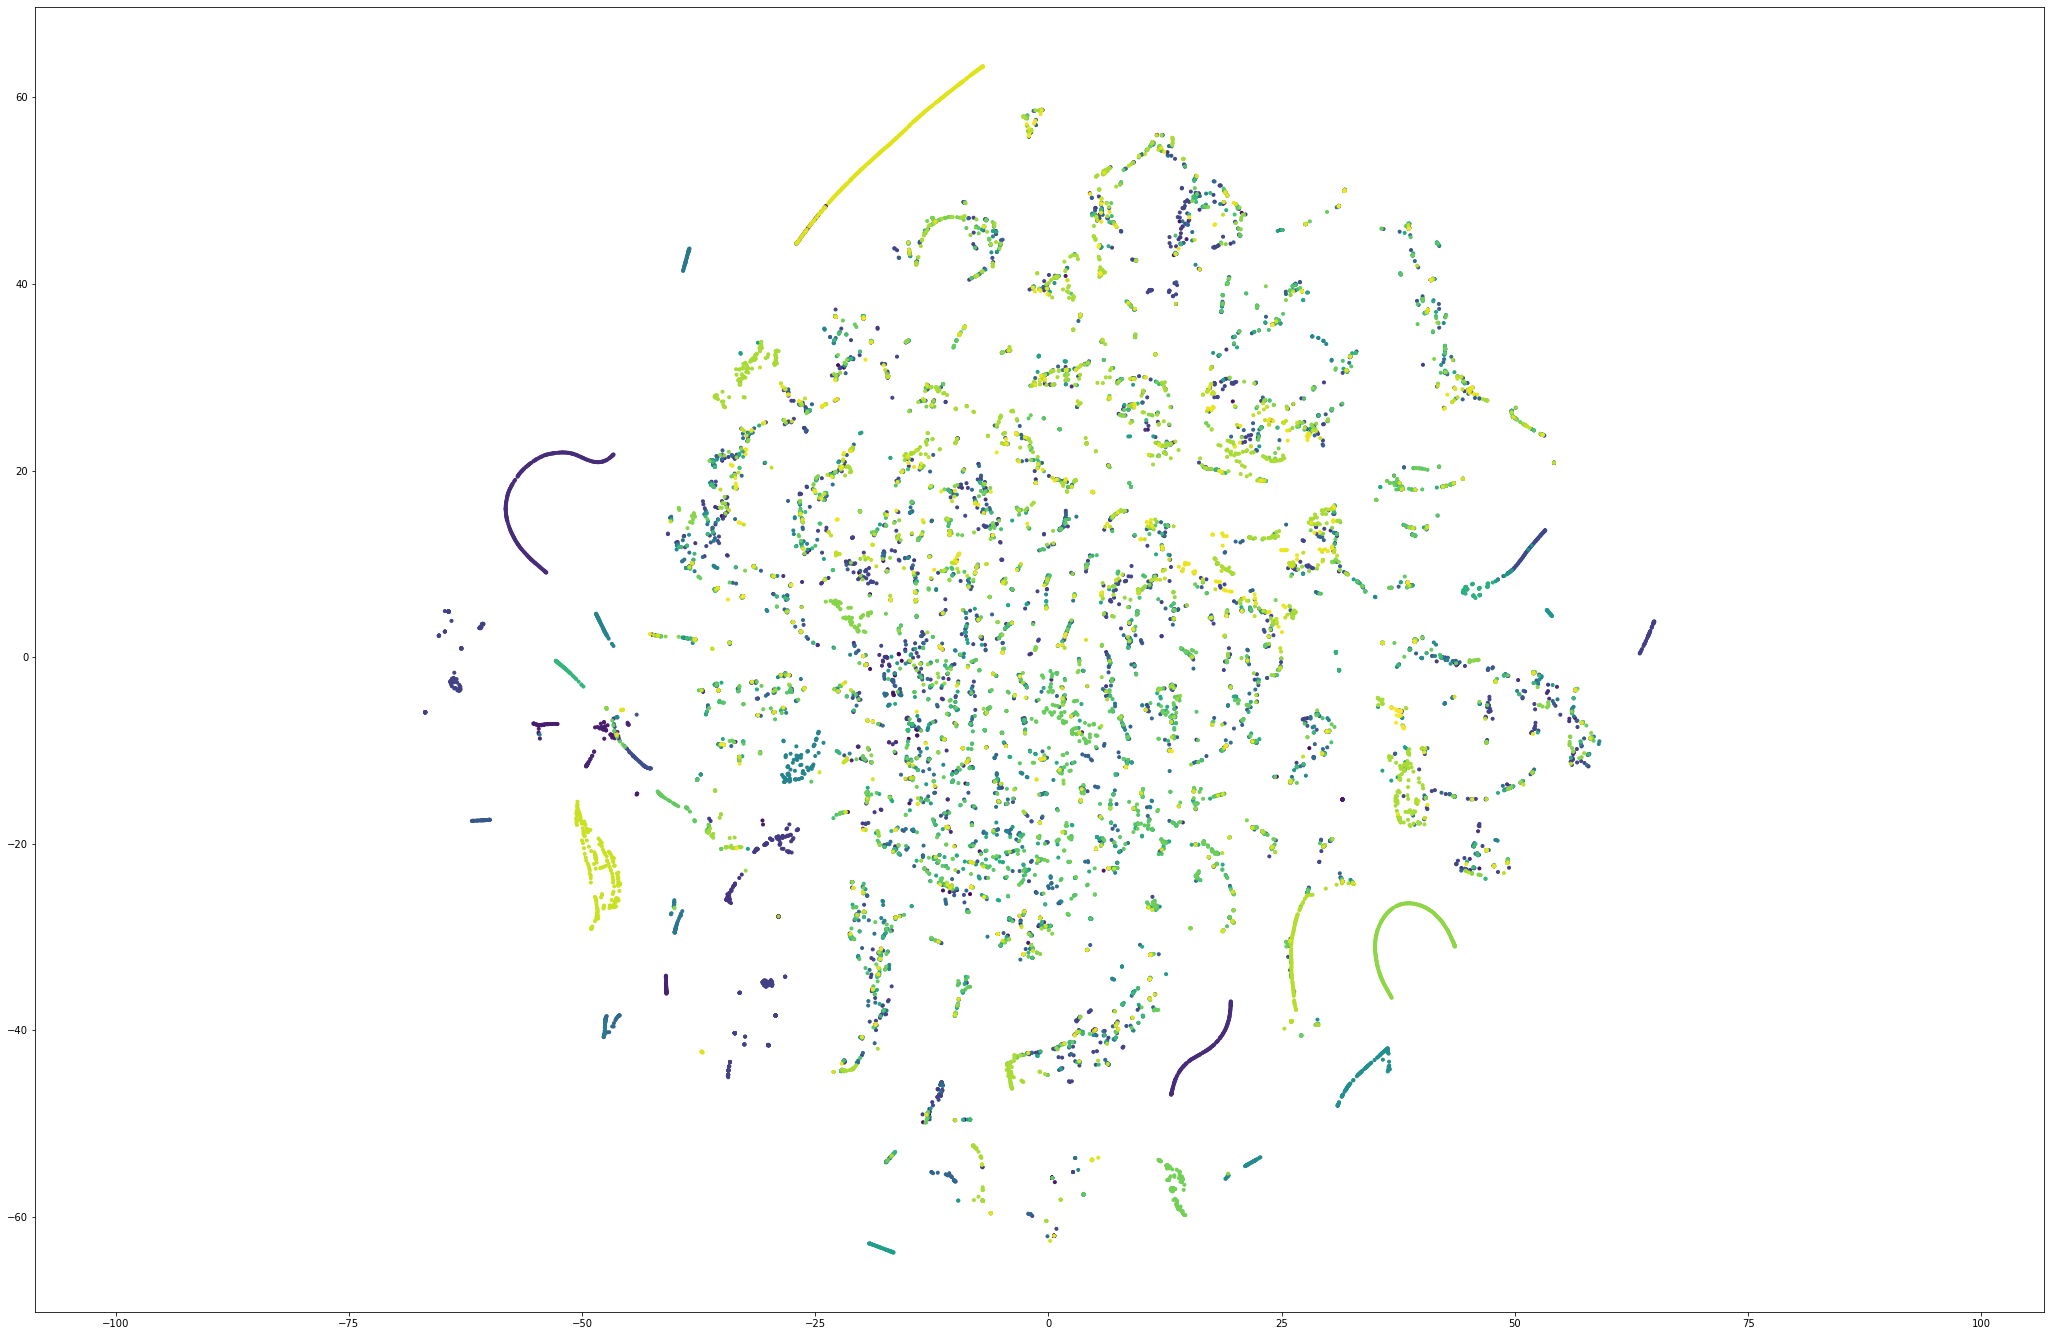

In [151]:
draw_tsne(
    np.concatenate([np.array(value['embedding']) for (key,value) in hundred_funcs.items()]),
    np.array(color_indices)
)

In [ ]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

In [ ]:
cluster_centers = {}
offset = 0
for key,value in tqdm(hundred_funcs.items()):
    setlength = len(value)
    cluster_centers[key] = [np.mean(reject_outliers(embeddings_tsne[offset:offset+setlength, 0])), np.mean(reject_outliers(embeddings_tsne[offset:offset+setlength, 1]))]
    offset += setlength
np.array(cluster_centers)

In [19]:
embeddings_tsne.shape

NameError: name 'embeddings_tsne' is not defined

In [44]:
concat_emb = np.concatenate([np.array(value['embedding']) for (key,value) in hundred_funcs.items()])

In [46]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
embeddings_tsne = TSNE(n_jobs=16).fit_transform(concat_emb)
vis_x_cb = embeddings_tsne[:, 0]
vis_y_cb = embeddings_tsne[:, 1]

<Figure size 1332x756 with 0 Axes>

In [47]:
names = []
for (key,value) in hundred_funcs.items():
    names.extend(value['method_name'])

In [48]:
bodies = []
for (key,value) in hundred_funcs.items():
    bodies.extend(value['method_body'])

In [58]:
concat_emb[0][:128]

array([-2.82918048e+00, -1.64019310e+00, -1.32132971e+00,  3.91993403e-01,
        7.48538226e-02,  5.82626283e-01,  8.36151421e-01, -7.54049897e-01,
       -2.01506400e+00, -1.02380049e+00,  2.68485355e+00, -2.23797575e-01,
        2.09688926e+00, -5.21395385e-01,  8.38541269e-01, -1.84201784e-02,
       -3.93266678e-01,  8.02736342e-01, -9.59942639e-01, -1.22344112e+00,
       -1.00908291e+00,  2.37859488e-01, -7.79654562e-01, -2.51859665e-01,
        1.00317979e+00,  1.27256358e+00, -9.28996086e-01, -1.55512169e-01,
       -1.55000305e+00,  4.08424467e-01,  7.03795910e-01,  7.97835529e-01,
       -1.20630968e+00,  1.28060147e-01,  3.09566468e-01,  1.88228142e+00,
        1.05102241e+00, -6.23274088e-01, -1.35173929e+00, -1.74224794e-01,
        5.93483090e-01, -4.95676070e-01,  4.02760744e-01,  1.56553757e+00,
        4.63799447e-01,  1.23025370e+00, -2.26306155e-01, -5.40693641e-01,
       -1.89532876e+00,  9.93109047e-01,  3.31416100e-01, -1.45814371e+00,
        6.97083175e-01,  

In [51]:
import pandas as pd

In [52]:
tsne_df = pd.DataFrame({'name': names, 'bodies': bodies, 'x': vis_x_cb, 'y': vis_y_cb})

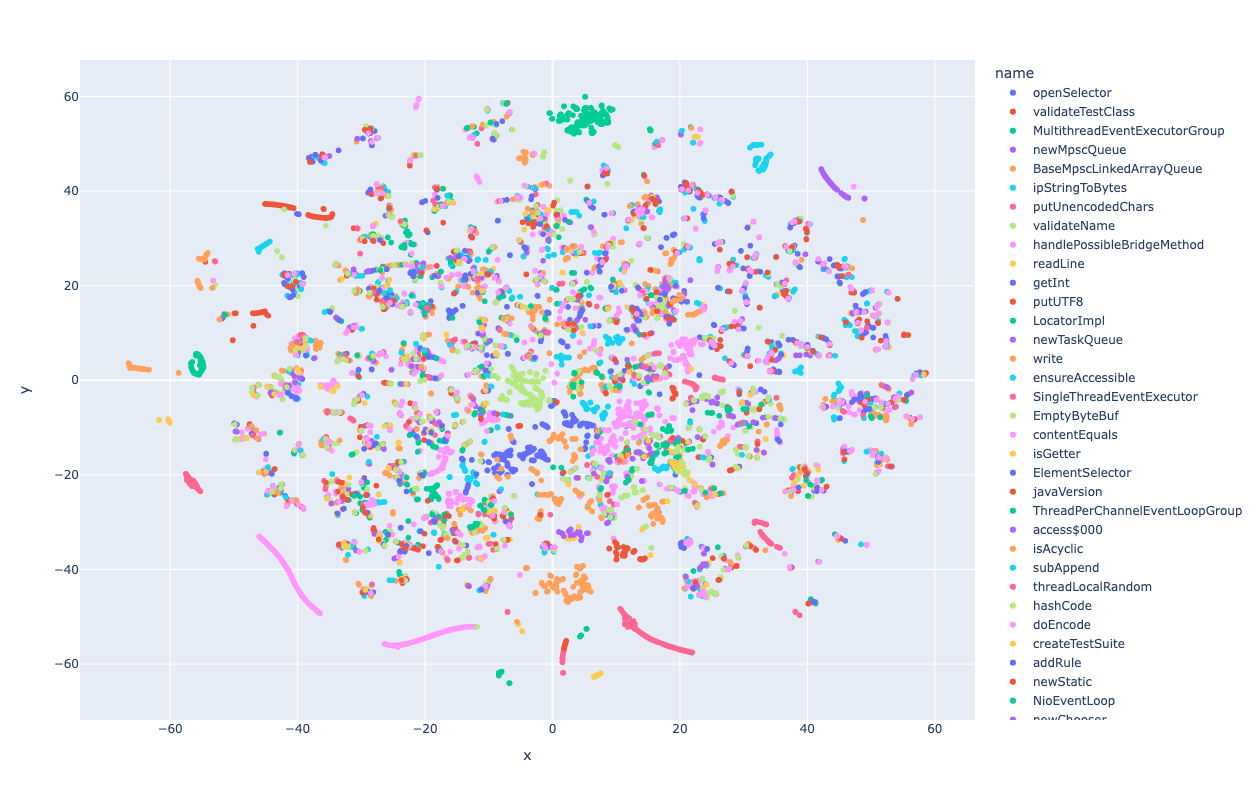

In [56]:
fig = px.scatter(tsne_df, x="x", y="y", hover_data=['name'], color="name", color_continuous_scale=px.colors.sequential.Turbo, height=800,width=1000)
fig.show()

In [ ]:
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111)
ax.scatter(vis_x_cb, vis_y_cb, c=np.array(color_indices), marker='.', cmap='tab10')
#for key,cluster in cluster_centers.items():
#    ax.text(cluster[0], cluster[1], key)
ax.set_aspect('equal', adjustable='datalim')
plt.savefig(f'tsne_labeled_{i}.pdf')

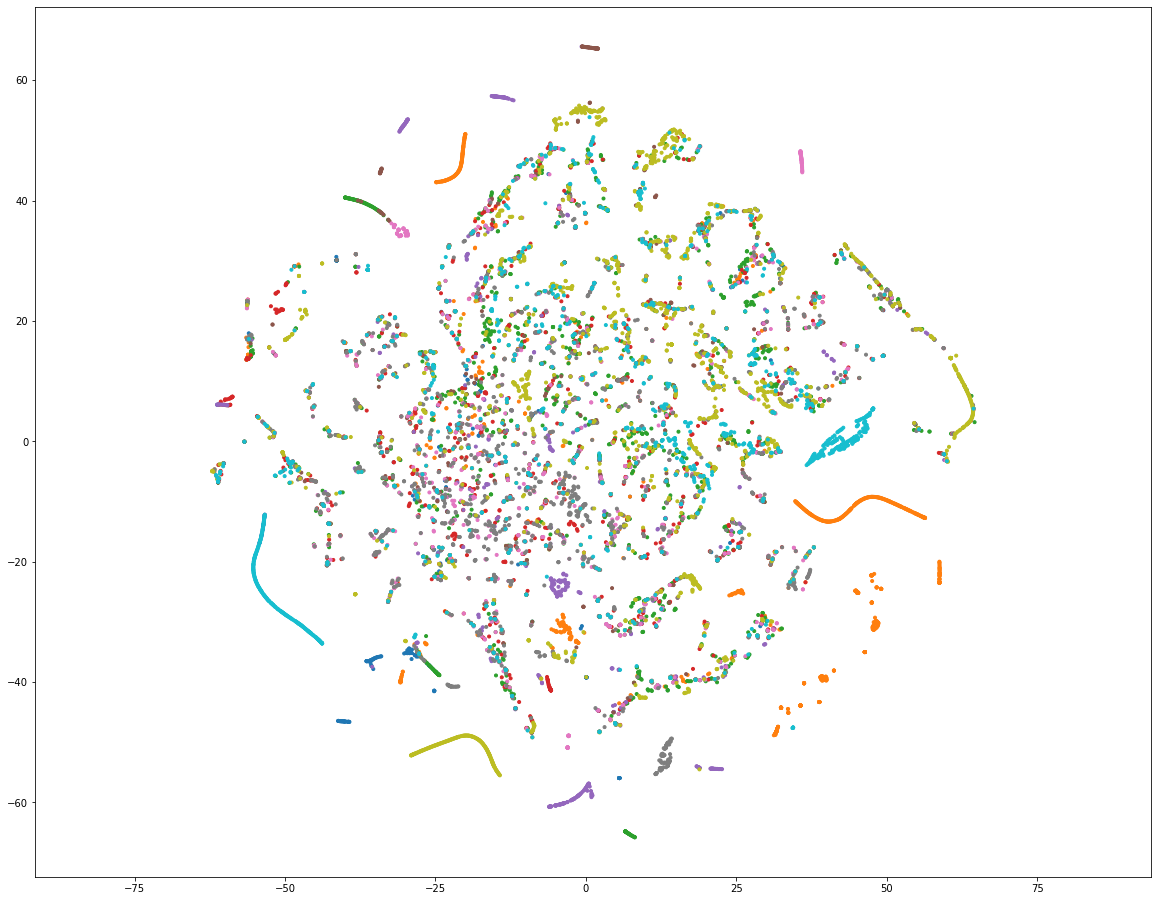

In [157]:
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111)
ax.scatter(vis_x_cb, vis_y_cb, c=np.array(color_indices), marker='.', cmap='tab10')
#for key,cluster in cluster_centers.items():
#    ax.text(cluster[0], cluster[1], key)
ax.set_aspect('equal', adjustable='datalim')
plt.savefig('tsne_labeled.pdf')
plt.show()

In [ ]:
draw_tsne(
    np.concatenate([np.concatenate([np.array(google_compare_emb['embedding']), np.array(func_CPI_google_emb['embedding'])])]),
    cm.rainbow(np.concatenate((np.zeros(google_compare_emb.shape[0]), np.ones(func_CPI_google_emb.shape[0]))))
)

In [ ]:
ten_k_emb = np.unique(np.array(ten_k_google['embedding']), axis=0)

In [ ]:
draw_tsne(
    ten_k_emb,
    cm.rainbow(np.linspace(0, 1, ten_k_emb.shape[0])) # what /exactly/ do the colors represent?
)

# Does our model return something useful when asked to fill a mask?

In [ ]:
from transformers import pipeline
from pprint import pprint

unmasker = pipeline(
    "fill-mask",
    model=tracebert_model,
    tokenizer=fast_tokenizer
)

In [ ]:
pprint(
    unmasker((
        "setSuccessorInMultimap "
        "[ENTRY] void com.google.common.collect.LinkedHashMultimap$ValueEntry "
        f"{unmasker.tokenizer.mask_token} "
        "[EXIT]"
    )))

In [ ]:
pprint(
    unmasker((
        f"{unmasker.tokenizer.mask_token} "
        "[ENTRY] void com.google.common.collect.LinkedHashMultimap$ValueEntry "
        "[EXIT]"
    ))
)

# Misc leftovers

#### L2 distance index + search

In [ ]:
random_example_emb = random_example_out['embedding']
#x = np.array([random_example_emb])#.astype(np.float32)
#q = np.array([random_example_emb])#.astype(np.float32)
faiss_l2_index = faiss.index_factory(512, "Flat", faiss.METRIC_L2)

In [ ]:
faiss_l2_index.is_trained

In [ ]:
faiss_l2_index.ntotal # should be one
#faiss_l2_index.train(training_vectors)
faiss_l2_index.add(random_example_emb)
distance, index = faiss_l2_index.search(random_example_emb, 1)
print(f"Distance by FAISS: {np.sqrt(distance)}, index: {index}")

In [ ]:
ds_with_embeddings = encoded_dataset_test.map(lambda example:
                            {'embeddings': np.array([0])})
                             #bertmodel(**fast_tokenizer(example["text"], max_length = 512, truncation=True, padding=True, return_tensors="pt")).hidden_states[-1][0].numpy()},
                                      #  batched=True)

# ds_with_embeddings = encoded_dataset_train.map(lambda example:
#                             {'embeddings': 
#                              bertmodel(**{'attention_mask': torch.tensor(example['attention_mask']),
#                                          'input_ids': torch.tensor(example['input_ids']),
#                                          'token_type_ids': torch.tensor(example['token_type_ids'])})[0].numpy()},
#                                         batched=True)

#    e = np.save("google_ex", bertmodel(**fast_tokenizer(ten_k_google.select(range(0,222))["text"],
#                                  max_length = 512, truncation=True, padding=True, return_tensors="pt",
#                                  )).hidden_states[-1].detach().numpy())
# print(e.shape)

    
    bertmodel(**fast_tokenizer(ten_examples_google["text"],
                                   max_length = 512, truncation=True, padding=True, return_tensors="pt",
                                  )).hidden_states[-1].shape

 netty = np.save("netty_ex", bertmodel(**fast_tokenizer(ten_k_netty["text"],
  max_length = 512, truncation=True, padding=True, return_tensors="pt"
 )).hidden_states[-1].detach().numpy())
index = faiss.IndexFlatL2(512)   # build the index
print(index.is_trained)
index.search(hidden_states.detach().numpy(),k=1)
from torch.nn import functional as F
import torch
#subset = 
smaller_dataset = encoded_dataset_test.shard(num_shards=4000, index=0)
text = "The capital of France, " + fast_tokenizer.mask_token + ",contains the Eiffel Tower."
input = fast_tokenizer.encode_plus(text, return_tensors = "pt").to("cuda")
mask_index = torch.where(input["input_ids"][0] == fast_tokenizer.mask_token_id)
logits = model(**input)
logits = logits.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_word = torch.argmax(mask_word, dim=1)
print(fast_tokenizer.decode(top_word))

softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = fast_tokenizer.decode([token])
   new_sentence = text.replace(fast_tokenizer.mask_token, word)
   print(new_sentence)
smaller_dataset
trainer_eval = trainer.evaluate(smaller_dataset, metric_key_prefix='no')

print(trainer_eval)
metrics = train_result.metrics
print(metrics)
#trainer.log_metrics("train", compute_metrics)
#trainer.save_metrics("train", compute_metrics)
#trainer.save_state()

print(metric.inputs_description)
model_predictions = model(smaller_dataset)
final_score = metric.compute(predictions=model_predictions, references=gold_references)

In [ ]:
test_input = fast_tokenizer(["performExpensiveLogSetup [ENTRY] void [CALL] java.io.PrintStream println java.lang.String void [EXIT] [CALL] java.lang.Math pow double|double double [CALL] java.lang.Math sqrt double double [CALL] java.io.PrintStream println java.lang.String void [EXIT]", "[EXIT]", ""], max_length = 512, truncation=True, padding=True, return_tensors="pt")
#fast_tokenizer.encode("performExpensiveLogSetup [ENTRY] void [CALL] java.io.PrintStream println java.lang.String void [EXIT] [CALL] java.lang.Math pow double|double double [CALL] java.lang.Math sqrt double double [CALL] java.io.PrintStream println java.lang.String void [EXIT]", max_length = 512, truncation=True, padding=True, return_tensors="pt")
hidden_states = bertmodel(**test_input).hidden_states

last_four_layers = [hidden_states[i] for i in (-1, -2, -3, -4)]
# cast layers to a tuple and concatenate over the last dimension
cat_hidden_states = torch.cat(tuple(last_four_layers), dim=-1)
print(cat_hidden_states.size())

# take the mean of the concatenated vector over the token dimension
cat_sentence_embedding = torch.mean(cat_hidden_states, dim=1).squeeze()
print(cat_sentence_embedding.size())
bertmodel(**fast_tokenizer("performExpensiveLogSetup [ENTRY] void [CALL] java.io.PrintStream println java.lang.String void [EXIT] [CALL] java.lang.Math pow double|double double [CALL] java.lang.Math sqrt double double [CALL] java.io.PrintStream println java.lang.String void [EXIT]", max_length = 512, truncation=True, padding=True, return_tensors="pt"))[1][0].numpy().shape
inputs = {
    "input_ids": encoded_dataset_test[0],
   #"attention_mask": batch[1]
}
input_sentence = torch.tensor(fast_tokenizer.encode("performExpensiveLogSetup [ENTRY] void [CALL] java.io.PrintStream println java.lang.String void [EXIT] [CALL] java.lang.Math pow double|double double [CALL] java.lang.Math sqrt double double [CALL] java.io.PrintStream println java.lang.String void [EXIT]", max_length = 512, truncation=True, padding=True)).unsqueeze(0)
output = bertmodel(input_sentence)
logits = output[0]
hidden_states = output[1]

In [ ]:
#assert both_embeddings.shape == (444, 512)

In [ ]:
#colors = cm.rainbow(np.linspace(0, 1, len(both_embeddings)))
colors = cm.rainbow(np.concatenate((np.zeros(222), np.ones(222)))) # TODO

In [ ]:
embeddings_tsne = TSNE(n_jobs=16).fit_transform(both_embeddings)

point_of_interest = [46,27] # what are these?

def find_idx(e):
    return np.linalg.norm(point_of_interest-e)

def get_idx(e):
    return np.argsort(np.linalg.norm(point_of_interest-e, axis=1))

points = 100
test_embeddings = sorted(embeddings_tsne, key=find_idx)
test_points = np.array(test_embeddings)
center = test_points[0:points].mean(axis=0)
width = np.linalg.norm(point_of_interest-test_points[0:points][-1], axis=-1)
test_embedding_indexs = get_idx(np.array(embeddings_tsne))[:points]
equivalent_points = np.array(embeddings_tsne)[test_embedding_indexs]
center = equivalent_points.mean(axis=0)
cir = plt.Circle(center, width, color='r', fill=False)

In [ ]:
vis_x_cb = embeddings_tsne[:, 0]
vis_y_cb = embeddings_tsne[:, 1]

In [ ]:
fig = plt.figure(figsize=(36,24))
ax = fig.add_subplot(111)
ax.scatter(vis_x_cb, vis_y_cb, color=colors, marker='.')
ax.set_aspect('equal', adjustable='datalim')
#ax.add_patch(cir)
plt.show()

In [ ]:
# embedding comes from bertmodel(**fast_tokenizer(ten_k_netty["text"],
 # max_length = 512, truncation=True, padding=True, return_tensors="pt"
 #)).hidden_states[-1].detach().numpy()
# embeddings[:,:1,:].squeeze()
#    both_embeddings = np.concatenate([embeddings_a, embeddings_b])
# both_embeddings.shape should be (444, 512) because 222 examples * 2 * 512 dimensions